In [1]:
import numpy as np
import qutip as qt
import cvxpy as cp
from scipy.linalg import logm, expm
from scipy.optimize import nnls
import matplotlib.pyplot as plt

In [2]:
def generate_hamiltonians(a_values, b_values):
    σz, σx = qt.sigmaz(), qt.sigmax()
    return {(a,b): 0.5*a*σz + 0.5*b*σx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    return qt.sesolve(H, psi0, tlist).states

# ---- Choi helpers (Y ⊗ X ordering; blocks are 2x2 on output Y) ----
def _J_block(J, i, j):
    r = slice(2*i, 2*(i+1)); c = slice(2*j, 2*(j+1))
    return J[r, c]

def _phi_of_rho_from_choi(J, rho):
    # Φ(ρ) = sum_{i,j} ρ_{j,i} * J_{i,j}
    Phi_rho = 0
    for i in range(2):
        for j in range(2):
            Phi_rho += rho[j, i] * _J_block(J, i, j)
    return Phi_rho

def _tp_constraints(J):
    # Tr_Y J = I_X  <=>  trace(J_ij) = δ_ij  (enforced entrywise)
    cons = [J >> 0]
    I2 = np.eye(2)
    for i in range(2):
        for j in range(2):
            cons.append(cp.trace(_J_block(J,i,j)) == (1.0 if i==j else 0.0))
    return cons

def _covariance_constraints(J, H):
    # [H ⊗ I - I ⊗ H^T, J] = 0  (linear equality)
    I2 = np.eye(2)
    G = np.kron(H, I2) - np.kron(I2, H.T)
    return [G @ J - J @ G == 0]

In [3]:
def fidelity_sdp_step(rho_qobj, sigma_qobj, H_qobj,
                      impose_covariance=True,
                      impose_passivity=False,
                      verbose = True):
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj.full()

    J = cp.Variable((4, 4), complex=True)  # Choi(Φ) on Y⊗X
    W = cp.Variable((2, 2), complex=True)  # fidelity witness
    t = cp.Variable()                       # sqrtF lower bound

    constraints = []
    constraints += _tp_constraints(J)
    if impose_covariance:
        constraints += _covariance_constraints(J, H)

    Phi_rho = _phi_of_rho_from_choi(J, rho)
    # Numerical stabilizers (redundant if J is CPTP & rho is state)
    constraints += [Phi_rho >> 0, cp.trace(Phi_rho) == 1]

    if impose_passivity:
        # ⟨H⟩ cannot increase: Tr(H Φ(ρ)) ≤ Tr(H ρ)
        lhs = cp.real(cp.trace(H @ Phi_rho))
        rhs = float(np.trace(H @ rho))
        constraints += [lhs <= rhs + 1e-12]

    # Uhlmann block: maximize t ≤ Re Tr(W) with block PSD
    block = cp.bmat([[Phi_rho, W],
                     [W.H,     sigma]])
    constraints += [block >> 0, cp.real(cp.trace(W)) >= t]

    prob = cp.Problem(cp.Maximize(t), constraints)
    prob.solve(solver=cp.SCS,
            verbose=verbose,
            eps_abs=1e-4,
            eps_rel=1e-4,
            max_iters=50000,
            acceleration_lookback=20)


    sqrtF = float(prob.value) if prob.value is not None else np.nan
    F = sqrtF**2 if np.isfinite(sqrtF) else np.nan

    return {
        "status": prob.status,
        "sqrtF": sqrtF,
        "fidelity": F,
        "J": None if J.value is None else J.value.copy(),
        "W": None if W.value is None else W.value.copy(),
        "Phi_rho": None if Phi_rho.value is None else Phi_rho.value.copy(),
    }

In [4]:
# ---- Kraus & superoperator ----
def kraus_from_choi(J_opt):
    J_q = qt.Qobj(J_opt, dims=[[2, 2], [2, 2]])
    evals, evecs = J_q.eigenstates()
    kraus_ops = []
    for lam, vec in zip(evals, evecs):
        if np.real(lam) > 1e-10:
            K = np.sqrt(lam) * vec.full().reshape(2, 2, order='F')
            kraus_ops.append(qt.Qobj(K))
    return kraus_ops

def super_from_kraus(kops):
    Phi = np.zeros((4, 4), dtype=complex)
    for K in kops:
        Kmat = K.full()
        Phi += np.kron(Kmat, Kmat.conj())
    return Phi


In [5]:
# ---- Phase-covariant GKSL fitting ----
def phase_covariant_basis():
    """Basis for L = ω*Bh + γ↓*Bd + γ↑*Bu + γφ*Bp."""
    sz = qt.sigmaz(); sp = qt.sigmap(); sm = qt.sigmam()
    H_unit = 0.5 * sz
    Lh = qt.liouvillian(H_unit, []).full()
    Ld = qt.liouvillian(0*sz, [sm]).full()
    Lu = qt.liouvillian(0*sz, [sp]).full()
    Lp = qt.liouvillian(0*sz, [sz]).full()
    return Lh, Ld, Lu, Lp

def nearest_phase_covariant_GKSL_from_channel(kraus_ops, eps=1e-7):
    """Fit a phase-covariant GKSL generator to a qubit channel (from Kraus ops)."""
    Phi = np.zeros((4,4), dtype=complex)
    for K in kraus_ops:
        K = K.full() if isinstance(K, qt.Qobj) else K
        Phi += np.kron(K, K.conj())

    # Regularized log
    Phi_reg = (1 - eps) * Phi + eps * np.eye(4)
    L_raw = logm(Phi_reg)

    # Project to TP: <vec(I)| L = 0
    vI = np.eye(2).reshape(-1,1,order='F')
    row = vI.conj().T @ L_raw
    denom = float(vI.conj().T @ vI)  # = 2
    L_raw_tp = L_raw - vI @ (row / denom)

    # Fit to phase-covariant basis
    Bh, Bd, Bu, Bp = phase_covariant_basis()
    A = np.column_stack([Bh.reshape(-1,1), Bd.reshape(-1,1), Bu.reshape(-1,1), Bp.reshape(-1,1)]).real
    b = np.real(L_raw_tp.reshape(-1,1))

    # ω free sign; rates ≥ 0 → split ω into ωp-ωm
    A_omega = np.column_stack([A[:,0:1], -A[:,0:1]])
    A_nnls = np.hstack([A_omega, A[:,1:]])
    x, _ = nnls(A_nnls, b.ravel())
    omega = x[0] - x[1]
    g_down, g_up, g_phi = x[2:]

    L_gksl = omega*Bh + g_down*Bd + g_up*Bu + g_phi*Bp
    Lq = qt.Qobj(L_gksl, dims=[[2,2],[2,2]])
    params = dict(omega=omega, gamma_down=g_down, gamma_up=g_up, gamma_phi=g_phi)
    return Lq, params


In [23]:
def _vecF(X): return X.reshape(-1, 1, order='F')
def _unvecF(v): return v.reshape(2, 2, order='F')

def choi_from_super(Phi):
    """Choi J of a superoperator Phi (4x4) using 'F' vec ordering."""
    J = np.zeros((4,4), dtype=complex)
    for i in range(2):
        for j in range(2):
            eij = np.zeros((2,2), complex); eij[i,j] = 1.0
            Φ_eij = _unvecF(Phi @ _vecF(eij))
            r = slice(2*i, 2*(i+1)); c = slice(2*j, 2*(j+1))
            J[r, c] = Φ_eij
    return J

In [7]:
def verify_L(L_qobj, t=0.1):
    """Checks: TP, Hermiticity preservation, CP of e^{tL} via Choi(J) ⪰ 0."""
    Lm = L_qobj.full()
    I2 = np.eye(2)
    vI = I2.reshape(-1,1,order='F')
    tp_err = np.linalg.norm(vI.conj().T @ Lm)  # should be ~0

    # Hermiticity preservation: act on a Hermitian sample and check Hermitian output
    rho = qt.rand_dm(2).full()
    rho = 0.5*(rho + rho.conj().T)
    out = (Lm @ rho.reshape(-1,1,order='F')).reshape(2,2,order='F')
    herm_err = np.linalg.norm(out - out.conj().T)

    Phi_t = expm(Lm * t)
    J = choi_from_super(Phi_t)
    eigs = np.linalg.eigvalsh(J)
    return tp_err, herm_err, eigs

In [8]:
def gksl_liouvillian(params):
    ω = params['omega']; γd = params['gamma_down']; γu = params['gamma_up']; γφ = params['gamma_phi']
    H_eff = 0.5 * ω * qt.sigmaz()
    c_ops = []
    if γd > 1e-12: c_ops.append(np.sqrt(γd) * qt.sigmam())
    if γu > 1e-12: c_ops.append(np.sqrt(γu) * qt.sigmap())
    if γφ > 1e-12: c_ops.append(np.sqrt(γφ) * qt.sigmaz())
    return qt.liouvillian(H_eff, c_ops)

In [9]:
def evolve_gksl_piecewise(gksl_params_list, tlist, rho0, exact_step=True):
    """Piecewise-constant GKSL evolution over tlist using params per step."""
    rho = rho0
    rho_list = [rho0]
    dt = tlist[1] - tlist[0]
    for params in gksl_params_list:
        L = gksl_liouvillian(params)
        rho_vec = qt.operator_to_vector(rho).full()
        if exact_step:
            Phi = expm(L.full() * dt)
            rho_vec_next = Phi @ rho_vec
        else:
            rho_vec_next = (np.eye(4) + L.full() * dt) @ rho_vec
        rho_next = qt.Qobj(rho_vec_next.reshape((2, 2), order='F'))
        rho_next = rho_next / rho_next.tr()  # renorm
        rho = rho_next
        rho_list.append(rho)
    return rho_list

In [10]:
# ----------------------------
# Problem setup
# ----------------------------
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)
hams = generate_hamiltonians(a_vals, b_vals)

key = (-2.0, -1.0)
H = hams[key]

# Common time grid for everything
tlist = np.linspace(0, 30, 100)

# Eigenbasis + initial/target
evals, evecs = H.eigenstates(sort='low')
ground, excited = evecs[0], evecs[1]
rho0 = qt.ket2dm(ground)
sigma_target = qt.ket2dm(excited)

# Unitary evolution of state for reference (on SAME tlist)
states_t = time_evolve_state(H, ground, tlist)


In [11]:
# ----------------------------
# SDP loop per time step (with optional constraints)
# ----------------------------
impose_covariance = False
impose_passivity = False

sdp_sqrtF = []
sdp_F = []
sdp_kraus_list = []
for psi_t in states_t:
    rho_t = qt.ket2dm(psi_t)
    out = fidelity_sdp_step(rho_t, sigma_target, H,
                            impose_covariance=impose_covariance,
                            impose_passivity=impose_passivity,
                            verbose=False)
    sdp_sqrtF.append(out["sqrtF"])
    sdp_F.append(out["fidelity"])
    kops = kraus_from_choi(out["J"]) if out["J"] is not None else []
    sdp_kraus_list.append(kops)

print(f"Solved {len(tlist)} SDPs. sqrtF range: {np.nanmin(sdp_sqrtF):.4f} … {np.nanmax(sdp_sqrtF):.4f}")
print(f"F range:      {np.nanmin(sdp_F):.4f} … {np.nanmax(sdp_F):.4f}")


Solved 100 SDPs. sqrtF range: 1.0000 … 1.0000
F range:      1.0000 … 1.0000


In [12]:
# ----------------------------
# Fit phase-covariant GKSL generators per step
# ----------------------------
gksl_results = []
for kops in sdp_kraus_list:
    if len(kops) == 0:
        Lq = qt.Qobj(np.zeros((4,4)), dims=[[2,2],[2,2]])
        params = dict(omega=0.0, gamma_down=0.0, gamma_up=0.0, gamma_phi=0.0)
    else:
        Lq, params = nearest_phase_covariant_GKSL_from_channel(kops, eps=1e-7)
    gksl_results.append((Lq, params))

L_gksl, params0 = gksl_results[0]
print("First-step fitted GKSL params:", params0)
tp_err, herm_err, eigs = verify_L(L_gksl, t=0.1)
print("First-step TP error:", tp_err)
print("First-step Herm error:", herm_err)
print("First-step Choi eigenvalues (e^{0.1L}):", np.round(eigs, 12))

gksl_params_list = [p for (_, p) in gksl_results]

First-step fitted GKSL params: {'omega': np.float64(0.0), 'gamma_down': np.float64(1.888728993220601), 'gamma_up': np.float64(1.6820598695135112), 'gamma_phi': np.float64(6.220773537887222)}
First-step TP error: 0.0
First-step Herm error: 0.0
First-step Choi eigenvalues (e^{0.1L}): [0.14145151 0.15883119 0.6086384  1.0910789 ]


/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_3563/3797216191.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(vI.conj().T @ vI)  # = 2


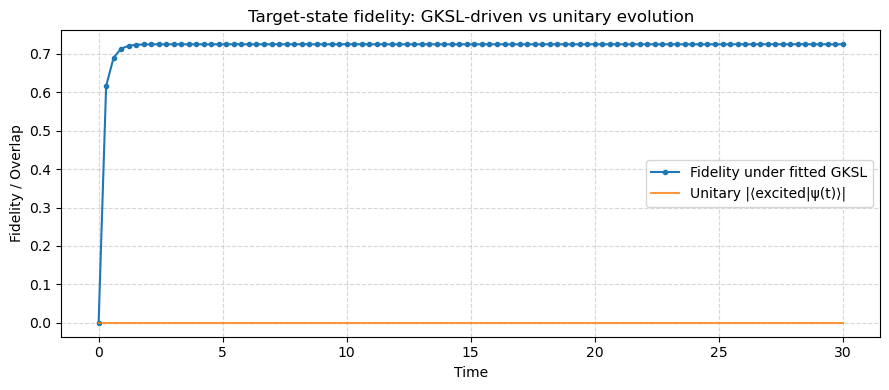

In [13]:
# ----------------------------
# Evolve under piecewise GKSL and compare
# ----------------------------
rho_list = evolve_gksl_piecewise(gksl_params_list, tlist, rho0, exact_step=True)
fids_gksl = [qt.fidelity(rho, excited) for rho in rho_list]  # length = len(tlist)+1; align quickly
fids_gksl = fids_gksl[:len(tlist)]  # match lengths for plotting

unitary_overlaps = [abs(excited.overlap(psi_t)) for psi_t in states_t]

plt.figure(figsize=(9,4))
plt.plot(tlist, fids_gksl, label="Fidelity under fitted GKSL", marker='o', ms=3)
plt.plot(tlist, unitary_overlaps, label="Unitary |⟨excited|ψ(t)⟩|", alpha=0.8)
plt.xlabel("Time"); plt.ylabel("Fidelity / Overlap")
plt.title("Target-state fidelity: GKSL-driven vs unitary evolution")
plt.grid(True, ls="--", alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()


In [14]:
# Case A – unconstrained
out = fidelity_sdp_step(rho_t, sigma_target, H,
                        impose_covariance=False,
                        impose_passivity=False)

# Case B – only covariance
out = fidelity_sdp_step(rho_t, sigma_target, H,
                        impose_covariance=True,
                        impose_passivity=False)

# Case C – only passivity
out = fidelity_sdp_step(rho_t, sigma_target, H,
                        impose_covariance=False,
                        impose_passivity=True)

(CVXPY) Nov 04 12:10:52 PM: Your problem has 21 variables, 42 constraints, and 0 parameters.
(CVXPY) Nov 04 12:10:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 04 12:10:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 04 12:10:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 04 12:10:52 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 04 12:10:52 PM: Compiling problem (target solver=SCS).
(CVXPY) Nov 04 12:10:52 PM: Reduction chain: Complex2Real -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Nov 04 12:10:52 PM: Applying reduction Complex2Real
(CVXPY) Nov 04 12:10:52 PM: Applying reduction FlipObjective
(CVXPY) Nov 04 12:10:52 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 04 12:10:52 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 04 12:10:52 PM: App

                                     CVXPY                                     
                                     v1.7.2                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 41, constraints m: 93
cones: 	  z: primal zero / dual free vars: 10
	  l: linear vars: 1
	  s: psd vars: 82,

(CVXPY) Nov 04 12:10:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 04 12:10:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 04 12:10:52 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 04 12:10:52 PM: Compiling problem (target solver=SCS).
(CVXPY) Nov 04 12:10:52 PM: Reduction chain: Complex2Real -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Nov 04 12:10:52 PM: Applying reduction Complex2Real
(CVXPY) Nov 04 12:10:52 PM: Applying reduction FlipObjective
(CVXPY) Nov 04 12:10:52 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 04 12:10:52 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 04 12:10:52 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Nov 04 12:10:52 PM: Applying reduction SCS
(CVXPY) Nov 04 12:10:52 PM: Finished problem compilation (took 1.515e-02 seconds).
(CVXPY)

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
------------------------------------------------------------------
	       SCS v3.2.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 41, constraints m: 94
cones: 	  z: primal zero / dual free vars: 10
	  l: linear vars: 2
	  s: psd vars: 82, ssize: 3
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 50000, normalize: 1

(CVXPY) Nov 04 12:10:53 PM: Problem status: optimal
(CVXPY) Nov 04 12:10:53 PM: Optimal value: 8.017e-05
(CVXPY) Nov 04 12:10:53 PM: Compilation took 1.515e-02 seconds
(CVXPY) Nov 04 12:10:53 PM: Solver (including time spent in interface) took 2.653e-01 seconds


 48250| 5.33e-05  3.13e-05  1.51e-04 -3.75e-04  4.04e-01  2.64e-01 
 48400| 1.34e-04  1.51e-04  3.94e-05 -9.99e-05  4.04e-01  2.65e-01 
------------------------------------------------------------------
status:  solved
timings: total: 2.65e-01s = setup: 4.14e-04s + solve: 2.65e-01s
	 lin-sys: 5.31e-02s, cones: 1.98e-01s, accel: 2.39e-03s
------------------------------------------------------------------
objective = -0.000100
------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


In [22]:
def extract_gksl_given_H(kraus_ops, H_known, dt=1e-2, eps=1e-10):
    """
    Given Kraus operators and a known Hamiltonian H_known,
    extract the GKSL generator: L = -i[H,·] + D[·].
    """
    d = H_known.shape[0]
    # Build superoperator Phi from Kraus ops
    Phi = np.zeros((d*d, d*d), dtype=complex)
    for K in kraus_ops:
        Kmat = K.full() if isinstance(K, qt.Qobj) else K
        Phi += np.kron(Kmat, Kmat.conj())

    # Regularized log to get generator
    Phi_reg = (1 - eps)*Phi + eps*np.eye(d*d)
    L_total = (1.0/dt) * logm(Phi_reg)

    # Hamiltonian part (superoperator)
    I = np.eye(d)
    L_H = -1j * (np.kron(H_known.full(), I) - np.kron(I, H_known.full().T))

    # Dissipator
    L_D = L_total - L_H
    # L_D = 0.5 * (L_D + L_D.conj().T)

    return L_total, L_H, L_D


# Example: pick one Kraus set from your SDP results
idx = 10  # choose a time step index to inspect
key = (-2.0, -1.0)
H = hams[key]
kraus_ops = sdp_kraus_list[idx]
print(H)
L_total, L_H, L_D = extract_gksl_given_H(kraus_ops, H, dt=1.0)  # dt can match your physical spacing

# Compare
print(f"Step {idx} GKSL decomposition:")
print("‣ ||L_total - (L_H+L_D)||:", np.linalg.norm(L_total - (L_H + L_D)))
print("‣ Hamiltonian contribution check:", np.linalg.norm(L_H.imag))
print("‣ Dissipator Frobenius norm:", np.linalg.norm(L_D))

# Convert to QuTiP for visualization
L_total_q = qt.Qobj(L_total, dims=[[2,2],[2,2]])
L_D_q = qt.Qobj(L_D, dims=[[2,2],[2,2]])

# Verify that dissipator is TP and CP
L_D = 0.5 * (L_D + L_D.conj().T)
tp_err, herm_err, eigs = verify_L(L_D_q, t=0.1)
print("Trace-preserving error:", tp_err)
print("Hermiticity-preserving error:", herm_err)
print("Choi eigenvalues (dissipator step):", np.round(eigs, 10))

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.  -0.5]
 [-0.5  1. ]]
Step 10 GKSL decomposition:
‣ ||L_total - (L_H+L_D)||: 1.6653345369377348e-16
‣ Hamiltonian contribution check: 3.1622776601683795
‣ Dissipator Frobenius norm: 22.813704365803044
Trace-preserving error: 2.4031851553611356e-06
Hermiticity-preserving error: 2.4711228408152333
Choi eigenvalues (dissipator step): [0.0307175  0.06372049 0.74692953 1.15863261]


In [24]:
def _vecF(X):   return X.reshape(-1, 1, order='F')
def _unvecF(v): return v.reshape(2, 2, order='F')

def _choi_from_super(Phi):
    """Choi J of a superoperator Phi (4x4 for qubit) using 'F' vec ordering."""
    J = np.zeros((4,4), dtype=complex)
    for i in range(2):
        for j in range(2):
            eij = np.zeros((2,2), complex); eij[i,j] = 1.0
            Φ_eij = _unvecF(Phi @ _vecF(eij))
            r = slice(2*i, 2*(i+1)); c = slice(2*j, 2*(j+1))
            J[r, c] = Φ_eij
    return J

def _LH_from_H(H):
    """Hamiltonian superoperator -i(H ⊗ I - I ⊗ H^T) in 'F' ordering."""
    Hm = H.full() if isinstance(H, qt.Qobj) else np.asarray(H)
    I2 = np.eye(Hm.shape[0])
    return -1j * (np.kron(Hm, I2) - np.kron(I2, Hm.T))

# ---------- robust, non-projecting verification ----------
def verify_L_strict(L_qobj, t=0.1, t_grid=None, H_known=None, verbose=True):
    """
    Verifies a qubit generator L (Qobj, dims [[2,2],[2,2]]) WITHOUT projecting or altering it.

    Checks:
      - TP (left): <I|L=0 and TP (right): L|I>=0
      - HP: L maps {I, σx, σy, σz} to Hermitian operators (max deviation)
      - For s in t_grid: channel TP <I|e^{sL} = <I| and Choi(e^{sL}) >= 0
      - Optional: compares anti-Hermitian part of L to known commutator superoperator from H_known

    Returns a dict of diagnostics.
    """
    Lm = L_qobj.full()
    d = 2
    I2 = np.eye(d)
    vI = _vecF(I2)

    # 1) TP diagnostics (both sides)
    tp_left  = np.linalg.norm(vI.conj().T @ Lm)   # <I|L
    tp_right = np.linalg.norm(Lm @ vI)            # L|I>

    # 2) HP diagnostics on Pauli basis
    basis = [qt.qeye(d).full(), qt.sigmax().full(), qt.sigmay().full(), qt.sigmaz().full()]
    hp_max = 0.0
    for X in basis:
        Xh = 0.5*(X + X.conj().T)
        Y = _unvecF(Lm @ _vecF(Xh))
        hp_max = max(hp_max, np.linalg.norm(Y - Y.conj().T))

    # 3) CPTP diagnostics for e^{sL}
    if t_grid is None:
        t_grid = [t/4, t/2, t]
    cptp = []
    for s in t_grid:
        Phi_s = expm(Lm * s)
        # channel TP: <I|Phi_s == <I|
        tp_channel = np.linalg.norm(vI.conj().T @ Phi_s - vI.conj().T)
        # Choi PSD
        J = _choi_from_super(Phi_s)
        # symmetrize tiny numeric asymmetry
        J = 0.5 * (J + J.conj().T)
        eigs = np.linalg.eigvalsh(J)
        cptp.append({
            "t": float(s),
            "tp_err_channel": float(tp_channel),
            "choi_min_eig":  float(np.min(eigs)),
            "choi_eigs": eigs
        })

    # 4) Optional: compare with known Hamiltonian part
    H_comp = None
    L_antiH_err = None
    if H_known is not None:
        L_H = _LH_from_H(H_known)
        L_sym  = 0.5*(Lm + Lm.conj().T)   # HP part (dissipator candidate)
        L_anti = 0.5*(Lm - Lm.conj().T)   # anti-HP part (should match L_H)
        L_antiH_err = float(np.linalg.norm(L_anti - L_H))
        H_comp = {
            "||L_anti - L_H||": L_antiH_err,
            "||L_sym||": float(np.linalg.norm(L_sym)),
            "||L_anti||": float(np.linalg.norm(L_anti))
        }

    if verbose:
        print("=== Strict generator verification (no projection) ===")
        print(f"TP left  ||<I|L||  = {tp_left:.3e}")
        print(f"TP right ||L|I>||  = {tp_right:.3e}")
        print(f"HP max over {{I,σx,σy,σz}} = {hp_max:.3e}")
        for item in cptp:
            print(f"s={item['t']:.3g}: TP(channel)={item['tp_err_channel']:.3e}, "
                  f"min λ(Choi)={item['choi_min_eig']:.3e}")
        if H_comp is not None:
            print("Hamiltonian split diagnostics:")
            for k, v in H_comp.items():
                print(f"  {k}: {v:.3e}")

    return {
        "tp_left": float(tp_left),
        "tp_right": float(tp_right),
        "hp_max": float(hp_max),
        "cptp": cptp,
        "ham_split": H_comp,
    }

In [25]:
# L_total_q is your Qobj superoperator for the extracted generator at step 10
diag = verify_L_strict(L_total_q, t=0.1, H_known=H, verbose=True)

# Or, if you want to check the dissipator alone (still no projection):
L_D_q = qt.Qobj(L_D, dims=[[2,2],[2,2]])
diag_D = verify_L_strict(L_D_q, t=0.1, verbose=True)

=== Strict generator verification (no projection) ===
TP left  ||<I|L||  = 2.403e-06
TP right ||L|I>||  = 1.517e+00
HP max over {I,σx,σy,σz} = 8.886e+00
s=0.025: TP(channel)=5.859e-08, min λ(Choi)=6.390e-03
s=0.05: TP(channel)=1.150e-07, min λ(Choi)=1.455e-02
s=0.1: TP(channel)=2.237e-07, min λ(Choi)=3.668e-02
Hamiltonian split diagnostics:
  ||L_anti - L_H||: 5.506e+00
  ||L_sym||: 2.214e+01
  ||L_anti||: 4.507e+00
=== Strict generator verification (no projection) ===
TP left  ||<I|L||  = 7.583e-01
TP right ||L|I>||  = 7.583e-01
HP max over {I,σx,σy,σz} = 1.481e+00
s=0.025: TP(channel)=1.879e-02, min λ(Choi)=8.066e-03
s=0.05: TP(channel)=3.727e-02, min λ(Choi)=1.633e-02
s=0.1: TP(channel)=7.332e-02, min λ(Choi)=3.285e-02


/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


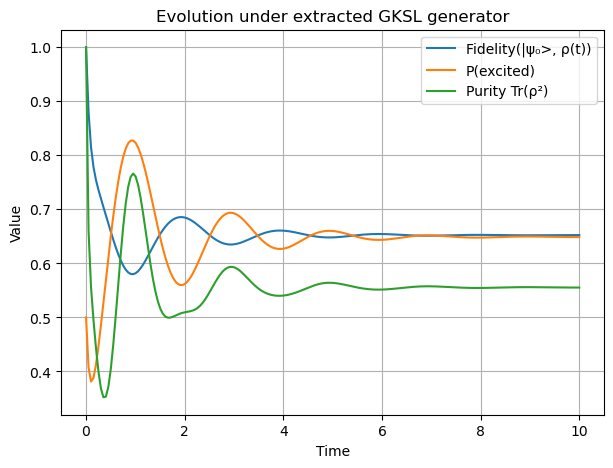

In [26]:
from scipy.linalg import expm

# --- Prepare the superposition initial state |ψ₀> = (|0> + |1>)/√2 ---
psi_super = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
rho_super0 = psi_super * psi_super.dag()

# --- Time grid (reuse your existing one or define a short one) ---
tlist = np.linspace(0, 10, 200)

# --- Liouvillian superoperator (from your GKSL extraction) ---
L_total_q = qt.Qobj(L_total, dims=[[2, 2], [2, 2]])  # if you have L_total as ndarray

# --- Evolution: ρ(t) = exp(L * t)ρ(0) ---
rho_list_super = []
for t in tlist:
    Phi_t = expm(L_total_q.full() * t)               # e^{tL}
    rho_vec = qt.operator_to_vector(rho_super0).full()
    rho_t_vec = Phi_t @ rho_vec
    rho_t = qt.Qobj(rho_t_vec.reshape((2, 2), order='F'))
    rho_list_super.append(rho_t)

# --- Extract observables for visualization ---
# Fidelity with initial state, excited-state population, purity
fidelity_list = [qt.fidelity(rho_super0, rho_t) for rho_t in rho_list_super]
p_excited = [qt.expect(qt.basis(2, 1) * qt.basis(2, 1).dag(), rho_t) for rho_t in rho_list_super]
purity_list = [np.real((rho_t * rho_t).tr()) for rho_t in rho_list_super]

# --- Plot results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(tlist, fidelity_list, label="Fidelity(|ψ₀>, ρ(t))")
plt.plot(tlist, p_excited, label="P(excited)")
plt.plot(tlist, purity_list, label="Purity Tr(ρ²)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Evolution under extracted GKSL generator")
plt.legend()
plt.grid(True)
plt.show()

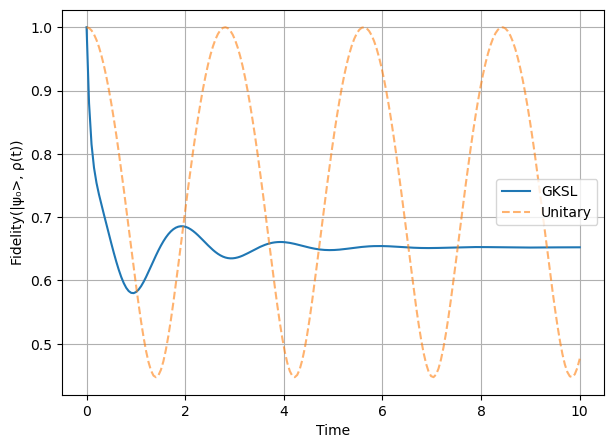

In [ ]:
rho_unitary_list = [qt.sesolve(H, psi_super, tlist).states[i] * qt.sesolve(H, psi_super, tlist).states[i].dag()
                    for i in range(len(tlist))]
fidelity_unitary = [qt.fidelity(rho_super0, rho) for rho in rho_unitary_list]

plt.figure(figsize=(7,5))
plt.plot(tlist, fidelity_list, label="GKSL")
plt.plot(tlist, fidelity_unitary, '--', label="Unitary", alpha=0.6)
plt.xlabel("Time")
plt.ylabel("Fidelity(|ψ₀>, ρ(t))")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(np.amin(fidelity_unitary))

0.44721840131623947


In [29]:
def fidelity_sdp_step(rho_qobj, sigma_qobj, H_qobj,
                      impose_covariance=True,
                      impose_passivity=False,
                      step_size=0.1, eta=1.0,
                      verbose=False):
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj.full()

    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    constraints = _tp_constraints(J)
    if impose_covariance:
        constraints += _covariance_constraints(J, H)

    Phi_rho = _phi_of_rho_from_choi(J, rho)
    constraints += [Phi_rho >> 0, cp.trace(Phi_rho) == 1]

    # --- small-step proximity (Frobenius proxy for diamond norm) ---
    constraints += [cp.norm(Phi_rho - rho, "fro") <= eta * step_size]

    if impose_passivity:
        lhs = cp.real(cp.trace(H @ Phi_rho))
        rhs = float(np.trace(H @ rho))
        constraints += [lhs <= rhs + 1e-12]

    block = cp.bmat([[Phi_rho, W],
                     [W.H, sigma]])
    constraints += [block >> 0, cp.real(cp.trace(W)) >= t]

    prob = cp.Problem(cp.Maximize(t), constraints)
    prob.solve(solver=cp.SCS, verbose=verbose,
               eps_abs=1e-4, eps_rel=1e-4,
               max_iters=20000)

    sqrtF = float(prob.value) if prob.value is not None else np.nan
    F = sqrtF**2 if np.isfinite(sqrtF) else np.nan
    return dict(status=prob.status, sqrtF=sqrtF, fidelity=F,
                J=None if J.value is None else J.value.copy(),
                Phi_rho=None if Phi_rho.value is None else Phi_rho.value.copy())


In [31]:
dt = tlist[1] - tlist[0]   # time step between successive t points

out = fidelity_sdp_step(
    rho_t, sigma_target, H,
    impose_covariance=True,
    impose_passivity=False,
    step_size=dt,           # use dt here
)

/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [33]:
kraus_ops = kraus_from_choi(out["J"])
Lq, params = nearest_phase_covariant_GKSL_from_channel(kraus_ops)
verify_L_strict(Lq, t=dt, H_known=H)

=== Strict generator verification (no projection) ===
TP left  ||<I|L||  = 0.000e+00
TP right ||L|I>||  = 3.876e-01
HP max over {I,σx,σy,σz} = 0.000e+00
s=0.0126: TP(channel)=0.000e+00, min λ(Choi)=1.183e-02
s=0.0251: TP(channel)=0.000e+00, min λ(Choi)=2.335e-02
s=0.0503: TP(channel)=0.000e+00, min λ(Choi)=4.545e-02
Hamiltonian split diagnostics:
  ||L_anti - L_H||: 3.168e+00
  ||L_sym||: 1.016e+01
  ||L_anti||: 1.938e-01


/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_3563/3797216191.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(vI.conj().T @ vI)  # = 2


{'tp_left': 0.0,
 'tp_right': 0.3875946169393347,
 'hp_max': 0.0,
 'cptp': [{'t': 0.01256281407035176,
   'tp_err_channel': 0.0,
   'choi_min_eig': 0.011833222385735993,
   'choi_eigs': array([0.01183322, 0.01522952, 0.07082973, 1.90210752])},
  {'t': 0.02512562814070352,
   'tp_err_channel': 0.0,
   'choi_min_eig': 0.023346205325297076,
   'choi_eigs': array([0.02334621, 0.03004689, 0.13490506, 1.81170185])},
  {'t': 0.05025125628140704,
   'tp_err_channel': 0.0,
   'choi_min_eig': 0.045445884555308624,
   'choi_eigs': array([0.04544588, 0.05848948, 0.24510141, 1.65096322])}],
 'ham_split': {'||L_anti - L_H||': 3.1682104407330782,
  '||L_sym||': 10.160831977812368,
  '||L_anti||': 0.19379730846966736}}